# System Workflow

![Screenshot](./Snapshots/flow_diagram.png)

## Step-1 :
## Load the Youtube Transcripts based on TimeStamp Chunks

In [3]:
from langchain_community.document_loaders import YoutubeLoader # Load the Youtube Transcript
from langchain_community.document_loaders.youtube import TranscriptFormat # To Get transcripts as timestamped chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
load_dotenv()

True

In [32]:
try:
    loader = YoutubeLoader.from_youtube_url(
        "https://www.youtube.com/watch?v=5KLyjoH8uew&t=2954s",
         language=["hi"],
         translation="en",
        transcript_format=TranscriptFormat.CHUNKS,
        chunk_size_seconds=60,
    )
    docs = loader.load()

    if len(docs) == 1:  # If only one chunk was returned
        print("docs len is 1 so RecCharTextSplit")
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,  # Adjust based on your needs
            chunk_overlap=100,
            length_function=len
        )
        docs = text_splitter.split_documents(docs)

    if docs:
        print(f"Successfully loaded {len(docs)} transcript chunks")
    else:
        print("No transcript data was loaded (empty result)")

except Exception as e:
    print(f"Error loading YouTube transcript: {str(e)}")
    docs = None  

if docs:
    pass
else:
    print("Failed to load transcript, cannot proceed")

Successfully loaded 56 transcript chunks


In [3]:
len(docs)

47

In [33]:
docs[2]

Document(metadata={'source': 'https://www.youtube.com/watch?v=5KLyjoH8uew&t=120s', 'start_seconds': 120, 'start_timestamp': '00:02:00'}, page_content="Whether to build a business in investment or Like updating Aadhaar card and PAN card to do the work of the government whether to learn easy methods of youtubeOn September 1, 2001, when over the US The world's biggest attack was happening At the same time, it was Osama who carried out this attack It was done on the eastern side of Afghanistan There is a mountainous area in me called Khost Sitting there with his bodyguards The entire attack was reported on the BBC Arabic Service I was taking updates of each and every detail and there As soon as this attack happened inside the US, then the attack Same day US Intelligence Agencies Which the CIA, FBI and NSA did without any time The investigation of this entire attack wasted The first thing I do is to All the passengers on board the flight what happened to their passports and visas There were

In [6]:
index= 0
print(docs[index].metadata)
print(docs[index].page_content)

{'source': 'https://www.youtube.com/watch?v=J5_-l7WIO_w&t=0s', 'start_seconds': 0, 'start_timestamp': '00:00:00'}
Hi guys, my name is Nitesh and you are welcome to my YouTube channel.  In this video also we will continue our lang chain playlist. Uh in the last video, we started studying rag and we focused on discussing the theory around rag.  Did I tell you what rags are?  Why is it needed ?  I also demonstrated comparing racks there using techniques like fine tuning.  And today's video is a continuation of the previous video. Where we will practically create a rag based system using lang chain.  The plan is that I will take a problem statement and create a rig based system around that problem statement and we are going to do all this code in lang chain. So whatever you have read till now in the previous four videos, document loaders, text splitters, vector strings, we will use all these in today's video and using these, we will create a rag base system.  On the whole it's going to be 

## Step-2
## Loading the embedding model and the llm

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

In [8]:
embedding_model = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from transformers import AutoTokenizer
# Initialize a llm model
# repo_id = "mistralai/Mistral-7B-Instruct-v0.3"
# # First load the tokenizer explicitly
# tokenizer = AutoTokenizer.from_pretrained(repo_id)
# llm1 = HuggingFaceEndpoint(
#     repo_id = repo_id,
#     temperature = 0.8,
#     max_new_tokens=500,
# )
# llm = ChatHuggingFace(llm=llm1,tokenizer=tokenizer)

c:\Users\Prabal Kuinkel\Desktop\Youtube-Conversational_AI\youtube_ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# !pip install langchain_groq

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name = "Qwen-Qwq-32b",max_tokens= 4000,model_kwargs={})

## Step-3
 
 ## Creating a vectordatabase using the Chroma db


In [11]:
# vector_store = FAISS.from_documents(docs, embedding_model)
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(docs, embedding_model)

In [12]:
# !pip install langchain-chroma
# !pip install lark

## Step-4 Defining the retriever
## Using the Metadatabased Filtering for retrievers

#### -> this retriever is known as self-query retriever

In [13]:
print(docs[index].metadata)

{'source': 'https://www.youtube.com/watch?v=J5_-l7WIO_w&t=0s', 'start_seconds': 0, 'start_timestamp': '00:00:00'}


In [14]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The link of the video",
        type="string"
    ),
    AttributeInfo(
        name="start_seconds",
        description="The starting second of the video chunk (in seconds as integer)",
        type="integer"  # Changed from string to integer
    ),
    AttributeInfo(
        name="start_timestamp",
        description="Human-readable timestamp (HH:MM:SS format)",
        type="string"
    )
]

In [15]:
# First get the base retriever from your vectorstore with increased k
base_vectorstore_retriever = vectorstore.as_retriever(
    # search_type = "mmr",
    search_kwargs={"k": 12,'lambda_mult':0.5}  # Increase this number as needed
)

In [16]:
metadata_field_info

[AttributeInfo(name='source', description='The link of the video', type='string'),
 AttributeInfo(name='start_seconds', description='The starting second of the video chunk (in seconds as integer)', type='integer'),
 AttributeInfo(name='start_timestamp', description='Human-readable timestamp (HH:MM:SS format)', type='string')]

In [17]:
document_content_description = "Transcript of a youtube video"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    # base_retriever = base_vectorstore_retriever,
    verbose=True,
    search_kwargs={"k": 12}  # Increase this number as needed

)

In [18]:
# This example only specifies a filter
# retriever.invoke("Create me a blog post about the video.")
# retriever.invoke("what is meant by multi query retriever ?")

## Step- 5 Creating tools

### Tool A. VectorStore Retriever tool (Convert the rag_chain into a tool)
Redirect to this tool if the user queries is regarding the Video content

### Tool B. DuckDuckSeach Tool
Redirect to this tool if the user query is general

In [19]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun #Search user queries Online

@tool
def retriever_vectorstore_tool(query:str)->str:
    """Use this tool when the user ask about:
    - content of the youtube video
    - Any queries specifically about the youtube video 
    - If the user query involves providing summary , or about specific time stamp ,blog etc
    Input should be the exact search query.
    The tool will perform a vectorstore search using retriever."""
    return retriever.invoke(query)



search = DuckDuckGoSearchRun()
@tool
def duckducksearch_tool(query: str) -> str:
    """Use this tool Only when:
    - The question is about the current news, affairs etc.
    
    Input should be the exact search query.
    The tool will perform a web search using DuckDuckGo.
    """
    return search.invoke(query)

## Step-6 Binding the llm with the tools

In [20]:
tools= [retriever_vectorstore_tool]
llm_with_tools=llm.bind_tools(tools=tools)

## Step-7 Define the langgraph workflow with memory

### Step-7.1 Define the State (flow of information through nodes)

In [21]:
from typing_extensions import Annotated, TypedDict 
from typing import List 
from langchain_core.messages import AnyMessage,HumanMessage,SystemMessage #can be either HumanMsg or AImsg or ToolMsg
from langgraph.graph.message import add_messages #Append the new messages insted of replacing


class State(TypedDict):
    """Represents the state of our graph"""
    messages:Annotated[List[AnyMessage],add_messages]

### Step-7.2 Define the Graph

In [22]:
from langgraph.graph import StateGraph, START, END
 # ToolNode is pre-built component that will invoke/execute the tool in behalf of the user and returns the tool_response
 # tools_condition is pre-built component that routes to ToolNode if the last message has tool call , otherwise routes to end
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display #to visualize the Graph
from langchain_core.messages import trim_messages # Trim the message and keep past 2 conversation
from langgraph.checkpoint.memory import MemorySaver #Implement langgraph memory


#### Step- 7.2.1 
#### Implement a ConversationalWindowBuffer Memory using langgraph

In [23]:
# A function that determines the best tool to server the user query 
def tool_calling_llm(State:State)->State:
    selected_msg = trim_messages(
        State["messages"],
        token_counter=len,  # <-- len will simply count the number of messages rather than tokens
        max_tokens=10,  # <-- allow up to 10 messages (includes all AI ,human, tool msg : So have context about 2 previous conversations)
        strategy="last",
        start_on="human",
        # Usually, we want to keep the SystemMessage
        # if it's present in the original history.
        # The SystemMessage has special instructions for the model.
        include_system=True,
        allow_partial=False,
    )
    return {'messages':llm_with_tools.invoke(selected_msg)}

In [24]:
tool_node = ToolNode(tools=tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'retriever_vectorstore_tool': StructuredTool(name='retriever_vectorstore_tool', description='Use this tool when the user ask about:\n    - content of the youtube video\n    - Any queries specifically about the youtube video \n    - If the user query involves providing summary , or about specific time stamp ,blog etc\n    Input should be the exact search query.\n    The tool will perform a vectorstore search using retriever.', args_schema=<class 'langchain_core.utils.pydantic.retriever_vectorstore_tool'>, func=<function retriever_vectorstore_tool at 0x000001420E0BCC20>)}, tool_to_state_args={'retriever_vectorstore_tool': {}}, tool_to_store_arg={'retriever_vectorstore_tool': None}, handle_tool_errors=True, messages_key='messages')

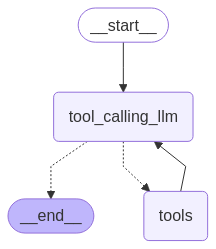

In [25]:
#Initializing the StateGraph
builder = StateGraph(state_schema=State)


#Adding the nodes
builder.add_node('tool_calling_llm',tool_calling_llm) # returns the tools that is to be used
builder.add_node('tools',tool_node) # Executes the specified tool

#Adding Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    # If the latest message from AI is a tool call -> tools_condition routes to tools
    # If the latest message from AI is a not a tool call -> tools_condition routes to LLM, then generate final response and END
    tools_condition
)
builder.add_edge('tools','tool_calling_llm')

memory = MemorySaver()

#Compile the graph
graph = builder.compile(
    checkpointer=memory
)

# View
display(Image(graph.get_graph().draw_mermaid_png()))



### Code Explaination / Flow :

    1. Starts with calling the 'tool_calling_llm' , which decides which tool is to be used to answer the user query .

    2. It is redirected to the 'tools_condition' function , where 
        
        Case I: If the Last 'AI Message' is a tool call ,then 'tools_conditions' automatically routes to 'tool_node' which will executes the specified tool and return the tool_response.

        Case II: If the last 'AI Message' is not a tool call, then 'tools_conditions' routes to 'tool_calling_llm' generates the final reponse and route to END


In [26]:
# Create a Unique Id for each user conversation
import uuid
thread_id = uuid.uuid4()
print(thread_id)
config = {"configurable": {"thread_id": thread_id}}

a0ec4772-88a1-4530-8559-c3222b3218f5


In [ ]:
query = "What ?"
response = graph.invoke({
    'messages': query
},config=config)

In [28]:
response

{'messages': [HumanMessage(content='What is this video about ?', additional_kwargs={}, response_metadata={}, id='130f77f8-58c9-4b39-8331-4ae9d2fb0b99'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fgpd', 'function': {'arguments': '{"query": "What is this video about?"}', 'name': 'retriever_vectorstore_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 201, 'prompt_tokens': 222, 'total_tokens': 423, 'completion_time': 0.467952208, 'prompt_time': 0.016661285, 'queue_time': 0.055607237000000004, 'total_time': 0.484613493}, 'model_name': 'Qwen-Qwq-32b', 'system_fingerprint': 'fp_07cd5d759a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9a1de5b8-0a1f-4ff2-aeab-9fbd8423d20f-0', tool_calls=[{'name': 'retriever_vectorstore_tool', 'args': {'query': 'What is this video about?'}, 'id': 'call_fgpd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 222, 'output_tokens': 201, 'total_tokens': 423}),
  ToolMessage(conten

In [29]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

What is this video about ?
================================== Ai Message ==================================
Tool Calls:
  retriever_vectorstore_tool (call_fgpd)
 Call ID: call_fgpd
  Args:
    query: What is this video about?
================================= Tool Message =================================
Name: retriever_vectorstore_tool

[Document(id='8f2cf85f-058a-4e01-9cda-2298dab0ab58', metadata={'source': 'https://www.youtube.com/watch?v=J5_-l7WIO_w&t=780s', 'start_seconds': 780, 'start_timestamp': '00:13:00'}, page_content='getting a big string like this.  In which the complete transcript of your entire video is visible to you at once.  Ok?  A so this function is not as it is a function. You have to run this chunk of code as it is.  Let me show you a couple of more videos. Like this is our rag video.  If you put this here and run it. So now an error will come here.  See what error is coming?  I will